# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

myList = [187, 69, 420, 117]



# this is new text

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [0]:
# The essentials, the iconic Trio, the triumvirate

import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt


In [4]:
# getting dataset from kaggle and converting to usable csv file
from google.colab import files
uploaded = files.upload()
# be weary of running this cell, took like 10 minutes to load the data

Saving renfe.csv to renfe.csv


In [5]:
# importing the data set now that its in usable csv form 
df = pd.read_csv('renfe.csv')
# taking a glance at the data set 
df.head(10)

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo
5,5,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 09:00:00,2019-05-29 11:38:00,AVE,60.30,Turista,Promo
6,6,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 09:45:00,2019-05-29 12:27:00,INTERCITY,62.20,Turista,Flexible
7,7,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 10:00:00,2019-05-29 12:32:00,AVE,47.30,Turista,Promo
8,8,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 11:00:00,2019-05-29 13:32:00,AVE,53.40,Turista,Promo
9,9,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 11:05:00,2019-05-29 13:41:00,ALVIA,NaN,Turista,Promo


In [6]:
# checking out the shape to see what we're working with
df.shape

(2579771, 10)

In [7]:
# checking out the various stats 
df.describe()

,Unnamed: 0,price
count,2.579771e+06,2.269090e+06
mean,1.289885e+06,6.338550e+01
std,7.447159e+05,2.578319e+01
min,0.000000e+00,1.545000e+01
25%,6.449425e+05,4.375000e+01
50%,1.289885e+06,6.030000e+01
75%,1.934828e+06,7.880000e+01
max,2.579770e+06,2.142000e+02


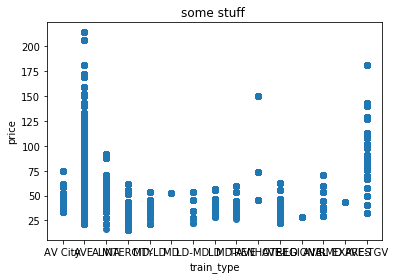

In [9]:
# scatter plot of some features I chose that seemed relevant
plt.scatter(df['train_type'], df['price'])

plt.xlabel('train_type')
plt.ylabel('price')

plt.title('some stuff ')

plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?


Answers:
1. Initially, I had to find a way to get a set of data that wasn't neccessarily usable to start with, and convert it into a format that I could work with using the tools we have here on Python(was quite a headache for a while lol). From there, I just did some of our basic analysis, primarily examining the dimensions of the data, as well as the core statisitcs such as mean, median, standard deviation etc. Then lastly, I charted what I thought to be relevant features from the data that one could use to intuitively draw conclusions. 

2. The most challenging part was taking a data set that wasn't in a nice csv file to begin with, and then getting into a nice easy to work with csv file. In reality, a pretty simple problem to solve, just took a while to find the actual notation to do so. 

3. The most interesting thing I learned would easily have to be the ability to now grab any set of data I find off the internet, save it as a csv file to my computer, and from there be able to import it on to Google colabs and work with the data using Python. 

4. From here, using more of the tools that were touched on in the precourse such as the tools in seaborn and sklearn, and being able to draw meaningful and relevant conclusions about the data I'm working with. 



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.